### Naive Risk Budgeting Strategies between the PSP and GHP

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [3]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)

In [5]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.036196,0.003787,0.325396,6.07189,-0.001348,-0.000406,1.592707,-0.000102


In [6]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [7]:
# build a 70-30 Stock-Bond mix
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.06042,0.004917,0.049469,2.498659,-0.002582,-0.002123,6.021718,0.0


However, both of these summaries are imperfect, since they aggregate across a wide distribution. In different situations one or the other might make sense, but for most individuals, the range of outcomes are what matters because we observe only one of the different possible scenarios.

Therefore, it make sense to example the range of possible outcomes and look at not just the average but also the less likely but possible outcomes.

## Distribution of Terminal Values and Measuring Risk Budget Efficiency

The basic idea is to measure the distribution of terminal values across all scenarios.

In [8]:
summaries = erk.summary_stats(rets_7030b)

In [9]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.027808,0.125903,-0.368529,3.228443,0.060117,0.079652,-0.017104,-0.303729
1,0.032267,0.114907,0.172573,2.736311,0.049678,0.059822,0.019064,-0.216662
2,0.089628,0.102329,-0.070027,3.630463,0.040985,0.060583,0.567039,-0.267690
3,0.156189,0.099762,-0.636297,3.791524,0.039104,0.056317,1.231113,-0.138419
4,0.011506,0.109578,-0.045599,3.148386,0.050676,0.066760,-0.164388,-0.253758


In [10]:
summaries.mean()

Annualized Return          0.054993
Annualized Vol             0.107204
Skewness                  -0.005533
Kurtosis                   2.918239
Cornish-Fisher VaR (5%)    0.045856
Historic CVaR (5%)         0.057965
Sharpe Ratio               0.226605
Max Drawdown              -0.208621
dtype: float64

In [11]:
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30")],
          axis=1)

,FI,Eq,70/30
mean,1.388473,2.000792,1.799664
std,0.115881,1.039326,0.630509
p_breach,NaN,0.060000,0.010000
e_short,NaN,0.112291,0.036073
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


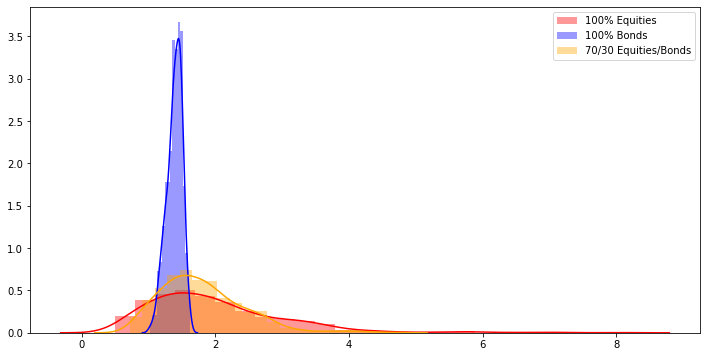

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

### Glide Paths for Allocation

A potential improvement over naive fixed mix is to risk budget by making a simplistic assumption that risk = time.

In other words, if you have more time, increase the risk budget. If you have less time, derisk. This is the thinking behind a Target Date Fund.

Let's write an allocator that defines the weights as a glidepath sthat starts at a starting weight and then gradually decreases the weights to equities over time to an ending weight. For example, you can start at 80% stocks at the start of the 10 year period and then gradually move to 20% stocks by the end of the 10 year period.

In [14]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30"),
           erk.terminal_stats(rets_g8020, name="Glide 80 to 20")],
          axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.388473,2.000792,1.799664,1.674299
std,0.115881,1.039326,0.630509,0.444086
p_breach,NaN,0.060000,0.010000,NaN
e_short,NaN,0.112291,0.036073,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


### Conclusion

Static or Naive risk budgeting involves allocating between the PSP and GHP using either a simple fixed mix or a blind glidepath. These can reduce the downside risk but come at the cost the expected return, and cannot be used to secure a minimum acceptable level of wealth or liabilities. In the next session, we'll examine dynamic approaches that will address the challenge of meeting a set of future liabilities such as replacement income, or a required level of wealth in the future.